This attempt uses a RandomForestClassifier instead of a DecisionTreeClassifier

In [1]:
import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

sys.path.append("../utils")

import config

pd.set_option("display.max_columns", None)


In [2]:
inspections_buffered_buildings_landcover = gpd.read_file(
    "/capstone/wildfire_prep/data/inspections_data/cleaned_status_with_id/inspections_buffered_buildings_landcover.geojson"
)



In [3]:
# landcover codes are coming in with the format '582.0', so let's make them integers
inspections_buffered_buildings_landcover["maj_landcover_code"] = (
    inspections_buffered_buildings_landcover["maj_landcover_code"].astype("Int64")
)

# make ZIP code an integer too
inspections_buffered_buildings_landcover["zip_code"] = (
    inspections_buffered_buildings_landcover["zip_code"].astype("Int64")
)

inspections_buffered_buildings_landcover.dtypes


system_created        datetime64[ms]
inspection_status             object
latitude                     float64
longitude                    float64
address_number                object
street                        object
apt_number                    object
city                          object
county                        object
state                         object
zip_code                       Int64
country                       object
address_full                  object
date                  datetime64[ms]
inspection_date               object
structure_type                object
year                           int32
address_id                     int32
maj_landcover_code             Int64
geometry                    geometry
dtype: object

In [4]:
data = inspections_buffered_buildings_landcover.drop(
    columns=[
        "system_created",
        "latitude",
        "longitude",
        "address_number",
        "street",
        "apt_number",
        "city",
        "county",
        "state",
        "country",
        "address_full",
        "date",
        "inspection_date",
        "geometry",
        'zip_code',
        'year',
        'address_id'
    ]
)

data.head()


,inspection_status,structure_type,maj_landcover_code
0,Compliant,School,582
1,Compliant,School,582
2,Compliant,School,582
3,Compliant,School,582
4,Compliant,School,582


In [5]:
categoricals = data.select_dtypes(include=["object"])

for col in categoricals:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

data.head()


,inspection_status,structure_type,maj_landcover_code
0,0,11,582
1,0,11,582
2,0,11,582
3,0,11,582
4,0,11,582


In [6]:
X = data.drop("inspection_status", axis=1)
y = data["inspection_status"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)


In [7]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.995231502845716


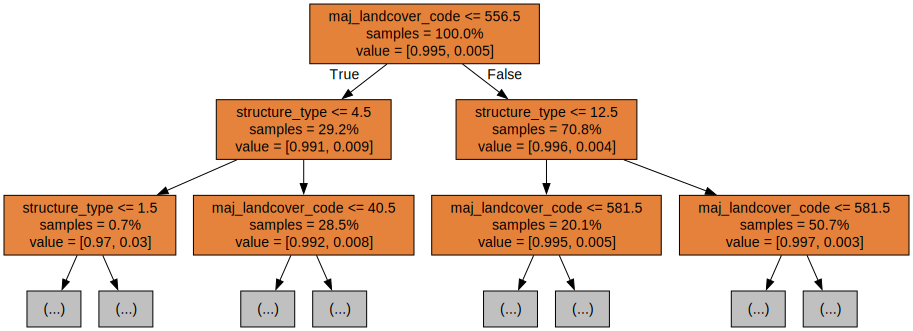

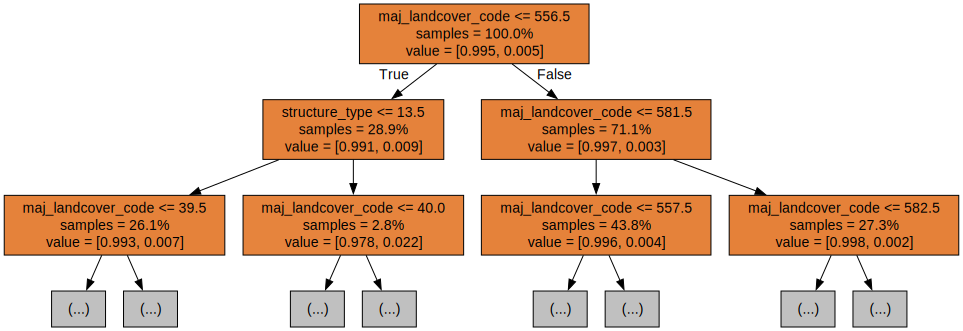

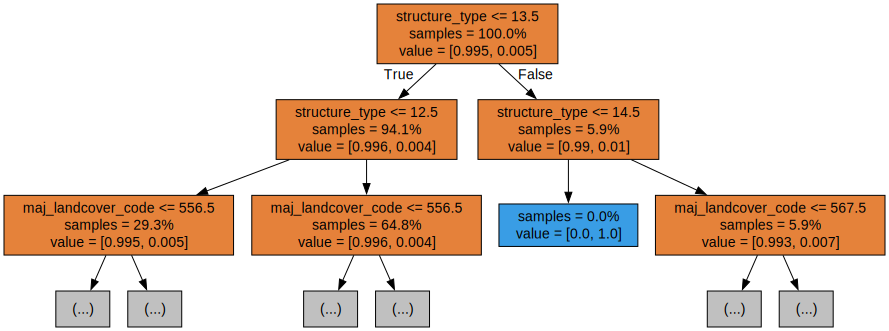

In [8]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(
        tree,
        feature_names=X_train.columns,
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True,
    )
    graph = graphviz.Source(dot_data)
    display(graph)


In [9]:
# param_dist = {"n_estimators": randint(50, 500), "max_depth": randint(1, 20)}

# # Create a random forest classifier
# rf = RandomForestClassifier()

# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5)

# # Fit the random search object to the data
# rand_search.fit(X_train, y_train)


In [10]:
param_dist = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(1, 20),
    "class_weight": [None, "balanced", "balanced_subsample"],
}

rf = RandomForestClassifier(random_state=42)

rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring="precision",
    refit=True,
)

rand_search.fit(X_train, y_train)

print("Best precision: ", rand_search.best_score_)
print("Best params:    ", rand_search.best_params_)


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best precision:  1.0
Best params:     {'class_weight': None, 'max_depth': 18, 'n_estimators': 127}


In [11]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", rand_search.best_params_)


Best hyperparameters: {'class_weight': None, 'max_depth': 18, 'n_estimators': 127}


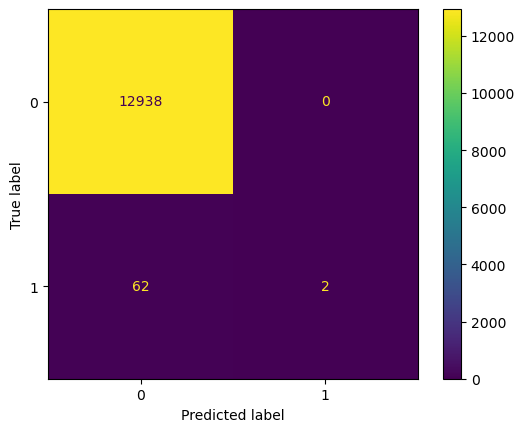

In [12]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [13]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.995231502845716
Precision: 1.0
Recall: 0.03125


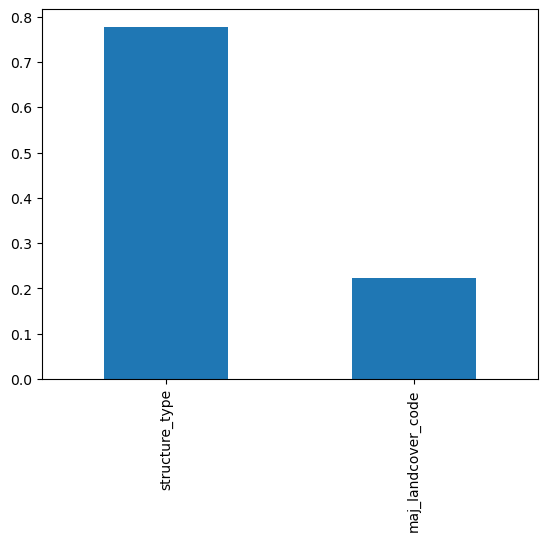

In [14]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(
    best_rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();


REMAKING IMAGE CLASSIFICATION from Lei's 03_random_forest

In [2]:
# Import training dataset
dataset = os.path.join(config.data_dir, "training_geometries", "training_gdf.parquet")

dataset = gpd.read_parquet(dataset)
dataset = dataset.drop(columns=["basemap_name", "geometry", "year", "month"])


In [5]:
# Import features
features = os.path.join(config.data_dir, "features", "features_mosaiks_4000.feather")
features = pd.read_feather(features).drop(columns=["unique_id"])
features["inspection_id"] = np.arange(1, len(features) + 1)
features.insert(0, "inspection_id", features.pop("inspection_id"))


In [7]:
features

inspection_id       X_0  X_1       X_2       X_3       X_4       X_5  \
0                  1  0.054892  0.0  0.015004  0.000000  0.238797  0.000466   
1                  2  0.024470  0.0  0.003108  0.000000  0.129467  0.000687   
2                  3  0.271383  0.0  0.126712  0.000000  0.976787  0.043854   
3                  4  0.097084  0.0  0.037654  0.000000  0.549639  0.001046   
4                  5  0.041986  0.0  0.008531  0.000000  0.253195  0.001353   
...              ...       ...  ...       ...       ...       ...       ...   
67575          67576  0.390350  0.0  0.262293  0.000786  1.184320  0.136650   
67576          67577  0.620665  0.0  0.296629  0.000000  1.358988  0.173100   
67577          67578  0.556022  0.0  0.353750  0.000000  1.496471  0.208025   
67578          67579  0.675105  0.0  0.384092  0.000000  1.633386  0.188037   
67579          67580  0.434330  0.0  0.253038  0.000000  1.362213  0.140951   

       X_6       X_7       X_8       X_9      X_10  X_11      X_12      X_13  \
0      0.0  0.055266  0.005605  0.000000  0.000000   0.0  0.016107  0.033777   
1      0.0  0.034108  0.012225  0.000000  0.000000   0.0  0.006849  0.006793   
2      0.0  0.528058  0.124882  0.000000  0.000000   0.0  0.139675  0.159956   
3      0.0  0.240636  0.017580  0.000000  0.000000   0.0  0.026863  0.048871   
4      0.0  0.036694  0.002605  0.000023  0.000000   0.0  0.019427  0.031545   
...    ...       ...       ...       ...       ...   ...       ...       ...   
67575  0.0  0.574472  0.152560  0.041207  0.015274   0.0  0.294296  0.362039   
67576  0.0  0.705775  0.217716  0.046306  0.000349   0.0  0.412139  0.491106   
67577  0.0  0.853633  0.305501  0.055803  0.004659   0.0  0.389178  0.447561   
67578  0.0  0.909275  0.271135  0.027995  0.000654   0.0  0.411502  0.547656   
67579  0.0  0.728457  0.233154  0.020168  0.001961   0.0  0.295227  0.339439   

       X_14  X_15      X_16      X_17  X_18  X_19      X_20  X_21      X_22  \
0       0.0   0.0  0.000554  0.004343   0.0   0.0  0.098842   0.0  0.088035   
1       0.0   0.0  0.005828  0.000000   0.0   0.0  0.055206   0.0  0.040181   
2       0.0   0.0  0.122122  0.001969   0.0   0.0  0.560241   0.0  0.393633   
3       0.0   0.0  0.007793  0.006705   0.0   0.0  0.298600   0.0  0.127497   
4       0.0   0.0  0.001135  0.001904   0.0   0.0  0.118113   0.0  0.045523   
...     ...   ...       ...       ...   ...   ...       ...   ...       ...   
67575   0.0   0.0  0.139363  0.096416   0.0   0.0  0.767630   0.0  0.484367   
67576   0.0   0.0  0.226405  0.188239   0.0   0.0  0.958993   0.0  0.633147   
67577   0.0   0.0  0.284135  0.150637   0.0   0.0  0.966618   0.0  0.689390   
67578   0.0   0.0  0.252019  0.167670   0.0   0.0  1.047005   0.0  0.775238   
67579   0.0   0.0  0.244335  0.091131   0.0   0.0  0.815697   0.0  0.592917   

           X_23  X_24      X_25      X_26  X_27      X_28      X_29  X_30  \
0      0.102126   0.0  0.000575  1.096743   0.0  0.000000  0.004691   0.0   
1      0.053264   0.0  0.000000  0.605803   0.0  0.000000  0.007520   0.0   
2      0.606285   0.0  0.000000  2.814656   0.0  0.000000  0.010600   0.0   
3      0.290800   0.0  0.000000  1.859055   0.0  0.000000  0.000043   0.0   
4      0.084537   0.0  0.000000  1.091881   0.0  0.000000  0.001210   0.0   
...         ...   ...       ...       ...   ...       ...       ...   ...   
67575  0.743121   0.0  0.027656  3.026754   0.0  0.000000  0.120460   0.0   
67576  0.890011   0.0  0.002341  3.495298   0.0  0.000300  0.071783   0.0   
67577  1.015488   0.0  0.005957  3.778639   0.0  0.000347  0.154547   0.0   
67578  1.085327   0.0  0.011426  3.987203   0.0  0.000000  0.127857   0.0   
67579  0.909349   0.0  0.000615  3.553511   0.0  0.000000  0.106830   0.0   

           X_31  X_32      X_33      X_34  X_35  X_36      X_37  X_38  \
0      0.004641   0.0  0.000000  0.000429   0.0   0.0  0.773836   0.0   
1      0.008966   0.0  0.000000  0.004441   0.0   0.0  0.417172   0.0   
2   

In [8]:
features.to_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/inspection_id_features.csv",
    index=False,
)
